## This notebook will help you train a raw Point-Cloud GAN.

(Assumes latent_3d_points is in the PYTHONPATH and that a trained AE model exists)

In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import numpy as np
import os.path as osp
import matplotlib.pylab as plt

from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.neural_net import MODEL_SAVER_ID

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.general_utils import plot_3d_point_cloud
from latent_3d_points.src.tf_utils import reset_tf_graph

from latent_3d_points.src.vanilla_gan import Vanilla_GAN
from latent_3d_points.src.w_gan_gp import W_GAN_GP
from latent_3d_points.src.generators_discriminators import point_cloud_generator,\
mlp_discriminator, leaky_relu

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# Use to save Neural-Net check-points etc.
top_out_dir = '../data/'          

# Top-dir of where point-clouds are stored.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/'

experiment_name = 'raw_gan_with_w_gan_loss'

n_pc_points = 2048                # Number of points per model.
class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

Give me the class name (e.g. "chair"): chair


In [5]:
# Load point-clouds.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
print 'Shape of DATA =', all_pc_data.point_clouds.shape

6778 pclouds were loaded. They belong in 1 shape-classes.
Shape of DATA = (6778, 2048, 3)


Set GAN parameters.

In [14]:
use_wgan = True     # Wasserstein with gradient penalty, or not?
n_epochs = 10       # Epochs to train.

plot_train_curve = True
save_gan_model = True
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])

# If true, every 'saver_step' epochs we produce & save synthetic pointclouds.
save_synthetic_samples = True
# How many synthetic samples to produce at each save step.
n_syn_samples = all_pc_data.num_examples

# Optimization parameters
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
beta = 0.5 # ADAM's momentum.

n_out = [n_pc_points, 3] # Dimensionality of generated samples.


discriminator = mlp_discriminator
generator = point_cloud_generator

if save_synthetic_samples:
    synthetic_data_out_dir = osp.join(top_out_dir, 'OUT/synthetic_samples/', experiment_name)
    create_dir(synthetic_data_out_dir)

if save_gan_model:
    train_dir = osp.join(top_out_dir, 'OUT/raw_gan', experiment_name)
    create_dir(train_dir)

In [15]:
reset_tf_graph()

if use_wgan:
    lam = 10
    disc_kwargs = {'b_norm': False}
    gan = W_GAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,
                    discriminator, generator,
                    disc_kwargs=disc_kwargs, beta=beta)
    
else:    
    leak = 0.2
    disc_kwargs = {'non_linearity': leaky_relu(leak), 'b_norm': False}
    gan = Vanilla_GAN(experiment_name, init_lr, n_out, noise_dim,
                 discriminator, generator, beta=beta, 
                 gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (0.07408812570351142, -0.1206897652225086)
INFO:tensorflow:../data/OUT/raw_gan/raw_gan_with_vanilla_gan_loss/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


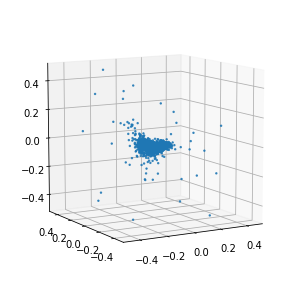

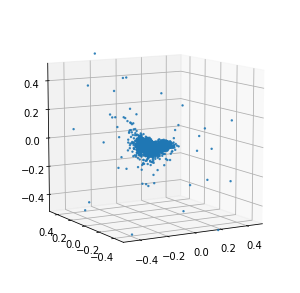

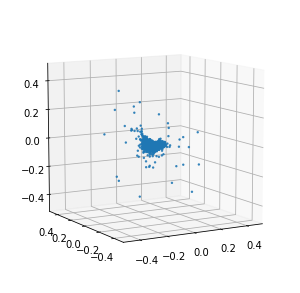

2 (-0.1694611712186425, 0.5825921777221892)
3 (-0.2628166483508216, 0.5641037192609575)
4 (-0.27953310001779486, 0.6531302498446571)


In [ ]:
# Train the GAN.
for _ in range(n_epochs):
    loss, duration = gan._single_epoch_train(all_pc_data, batch_size, noise_params)
    epoch = int(gan.sess.run(gan.increment_epoch))
    print epoch, loss

    if save_gan_model and epoch in saver_step:
        checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)

    if save_synthetic_samples and epoch in saver_step:
        syn_data = gan.generate(n_syn_samples, noise_params)
        np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
        for k in range(3):  # plot three (synthetic) random examples.
            plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],
                               in_u_sphere=True)

    train_stats.append((epoch, ) + loss)

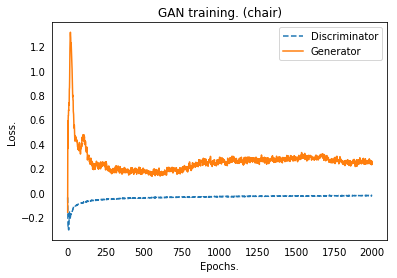

In [27]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('GAN training. (%s)' %(class_name))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')